# Week 3: Using RNNs to predict time series

Welcome! In the previous assignment you used a vanilla deep neural network to create forecasts for generated time series. This time you will be using Tensorflow's layers for processing sequence data such as Recurrent layers or LSTMs to see how these two approaches compare.

Let's get started!

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

## Generating the data

The next cell includes a bunch of helper functions to generate and plot the time series:

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

You will be generating the same time series data as in last week's assignment.

**Notice that this time all the generation is done within a function and global variables are saved within a dataclass. This is done to avoid using global scope as it was done in during the first week of the course.**

If you haven't used dataclasses before, they are just Python classes that provide a convenient syntax for storing data. You can read more about them in the [docs](https://docs.python.org/3/library/dataclasses.html).



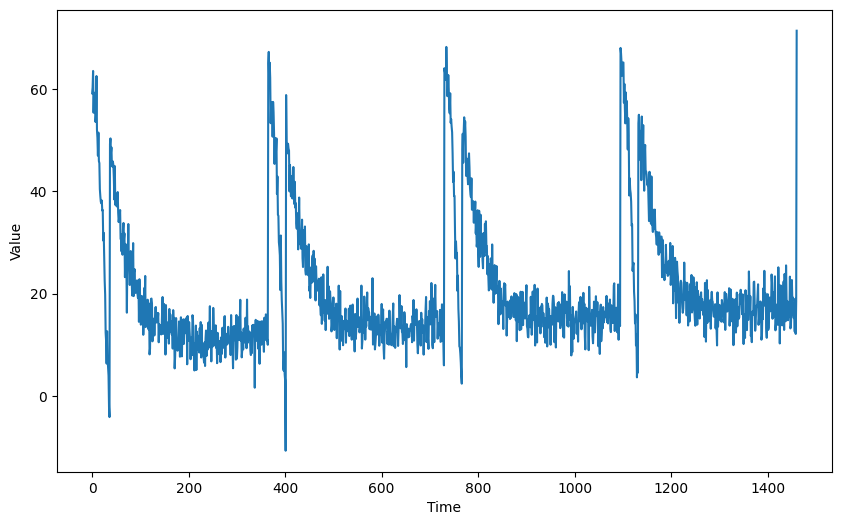

In [3]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series


# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000
    

# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Processing the data

Since you already coded the `train_val_split` and `windowed_dataset` functions during past week's assignments, this time they are provided for you:



In [4]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [5]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

# Apply the transformation to the training set
dataset = windowed_dataset(series_train)

## Defining the model architecture

Now that you have a function that will process the data before it is fed into your neural network for training, it is time to define you layer architecture. Unlike previous weeks or courses in which you define your layers and compile the model in the same function, here you will first need to complete the `create_uncompiled_model` function below. 

This is done so you can reuse your model's layers for the learning rate adjusting and the actual training.

Hint:
- Fill in the `Lambda` layers at the beginning and end of the network with the correct lamda functions.
- You should use `SimpleRNN` or `Bidirectional(LSTM)` as intermediate layers.
- The last layer of the network (before the last `Lambda`) should be a `Dense` layer.

In [10]:
def create_uncompiled_model():

    ### START CODE HERE
    
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 100.0)
    ]) 

    ### END CODE HERE

    return model

In [11]:
# Test your uncompiled model
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(dataset)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Your current architecture is compatible with the windowed dataset! :)


2024-07-10 12:32:09.690195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Adjusting the learning rate - (Optional Exercise)

As you saw in the lecture you can leverage Tensorflow's callbacks to dinamically vary the learning rate during training. This can be helpful to get a better sense of which learning rate better acommodates to the problem at hand.

**Notice that this is only changing the learning rate during the training process to give you an idea of what a reasonable learning rate is and should not be confused with selecting the best learning rate, this is known as hyperparameter optimization and it is outside the scope of this course.**

For the optimizers you can try out:
- [`tf.keras.optimizers.Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
- [`tf.keras.optimizers.SGD`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) with a momentum of 0.9

In [12]:
def adjust_learning_rate():
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
    
    ### START CODE HERE
    
    # Select your optimizer
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    ### END CODE HERE
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [13]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate()

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 51.7269 - mae: 52.2262 - learning_rate: 1.0000e-06
Epoch 2/100
29/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.3338 - mae: 9.8188 

2024-07-10 12:32:35.411864: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.0868 - mae: 9.5705 - learning_rate: 1.1220e-06
Epoch 3/100
27/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.7081 - mae: 6.1788

2024-07-10 12:32:35.692060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.6608 - mae: 6.1305 - learning_rate: 1.2589e-06
Epoch 4/100
14/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.1580 - mae: 5.6168

2024-07-10 12:32:35.947770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8874 - mae: 5.3471 - learning_rate: 1.4125e-06
Epoch 5/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3575 - mae: 4.8178

2024-07-10 12:32:36.256778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4284 - mae: 4.8891 - learning_rate: 1.5849e-06
Epoch 6/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3963 - mae: 4.8586

2024-07-10 12:32:36.552333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3823 - mae: 4.8441 - learning_rate: 1.7783e-06
Epoch 7/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.0160 - mae: 4.4689

2024-07-10 12:32:36.913792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.1183 - mae: 4.5724 - learning_rate: 1.9953e-06
Epoch 8/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.0405 - mae: 4.4994

2024-07-10 12:32:37.209551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.9471 - mae: 4.4084 - learning_rate: 2.2387e-06
Epoch 9/100
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.0598 - mae: 4.5233

2024-07-10 12:32:37.504431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.9830 - mae: 4.4450 - learning_rate: 2.5119e-06
Epoch 10/100
13/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6765 - mae: 4.1390 

2024-07-10 12:32:37.799582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6290 - mae: 4.0914 - learning_rate: 2.8184e-06
Epoch 11/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0157 - mae: 3.4708

2024-07-10 12:32:38.131099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2636 - mae: 3.7208 - learning_rate: 3.1623e-06
Epoch 12/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0962 - mae: 3.5515

2024-07-10 12:32:38.425735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2536 - mae: 3.7100 - learning_rate: 3.5481e-06
Epoch 13/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8505 - mae: 3.3083

2024-07-10 12:32:38.718668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0370 - mae: 3.4956 - learning_rate: 3.9811e-06
Epoch 14/100
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2382 - mae: 3.7055

2024-07-10 12:32:39.009748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.1508 - mae: 3.6172 - learning_rate: 4.4668e-06
Epoch 15/100
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.3152 - mae: 3.7746

2024-07-10 12:32:39.300293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2264 - mae: 3.6856 - learning_rate: 5.0119e-06
Epoch 16/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.3096 - mae: 3.7611

2024-07-10 12:32:39.594018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2832 - mae: 3.7410 - learning_rate: 5.6234e-06
Epoch 17/100
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.1007 - mae: 3.5650

2024-07-10 12:32:39.891679: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0498 - mae: 3.5138 - learning_rate: 6.3096e-06
Epoch 18/100
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.7057 - mae: 4.1768

2024-07-10 12:32:40.183025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.7278 - mae: 4.1997 - learning_rate: 7.0795e-06
Epoch 19/100
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.1495 - mae: 3.6193

2024-07-10 12:32:40.475956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.1618 - mae: 3.6309 - learning_rate: 7.9433e-06
Epoch 20/100
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9460 - mae: 3.4118

2024-07-10 12:32:40.767497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0952 - mae: 3.5609 - learning_rate: 8.9125e-06
Epoch 21/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.3642 - mae: 3.8292

2024-07-10 12:32:41.056980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2343 - mae: 3.6983 - learning_rate: 1.0000e-05
Epoch 22/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7187 - mae: 3.1841

2024-07-10 12:32:41.355034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9705 - mae: 3.4362 - learning_rate: 1.1220e-05
Epoch 23/100
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7082 - mae: 3.1652

2024-07-10 12:32:41.647482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7753 - mae: 3.2355 - learning_rate: 1.2589e-05
Epoch 24/100
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7973 - mae: 3.2550

2024-07-10 12:32:41.938397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0565 - mae: 3.5184 - learning_rate: 1.4125e-05
Epoch 25/100
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9046 - mae: 3.3754

2024-07-10 12:32:42.230020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0910 - mae: 3.5627 - learning_rate: 1.5849e-05
Epoch 26/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2149 - mae: 3.6809

2024-07-10 12:32:42.521287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2031 - mae: 3.6689 - learning_rate: 1.7783e-05
Epoch 27/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8081 - mae: 3.2683

2024-07-10 12:32:42.825757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9876 - mae: 3.4497 - learning_rate: 1.9953e-05
Epoch 28/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7950 - mae: 3.2577

2024-07-10 12:32:43.124663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9844 - mae: 3.4514 - learning_rate: 2.2387e-05
Epoch 29/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9915 - mae: 3.4684

2024-07-10 12:32:43.417731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.1289 - mae: 3.6018 - learning_rate: 2.5119e-05
Epoch 30/100
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3441 - mae: 4.8249

2024-07-10 12:32:43.711804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.0355 - mae: 4.5132 - learning_rate: 2.8184e-05
Epoch 31/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.4528 - mae: 2.9177

2024-07-10 12:32:44.004868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0030 - mae: 3.4731 - learning_rate: 3.1623e-05
Epoch 32/100
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.9354 - mae: 4.4067

2024-07-10 12:32:44.296895: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.0314 - mae: 4.5043 - learning_rate: 3.5481e-05
Epoch 33/100
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.5366 - mae: 4.0144

2024-07-10 12:32:44.587517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.5133 - mae: 3.9908 - learning_rate: 3.9811e-05
Epoch 34/100
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2008 - mae: 4.6747

2024-07-10 12:32:44.879991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.1853 - mae: 4.6596 - learning_rate: 4.4668e-05
Epoch 35/100
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.3446 - mae: 3.8224

2024-07-10 12:32:45.182020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.4595 - mae: 3.9363 - learning_rate: 5.0119e-05
Epoch 36/100
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3448 - mae: 4.8220

2024-07-10 12:32:45.472027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.0992 - mae: 4.5754 - learning_rate: 5.6234e-05
Epoch 37/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2105 - mae: 3.6848

2024-07-10 12:32:45.762594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.4339 - mae: 3.9073 - learning_rate: 6.3096e-05
Epoch 38/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6104 - mae: 4.0783

2024-07-10 12:32:46.055600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.9403 - mae: 4.4121 - learning_rate: 7.0795e-05
Epoch 39/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.7280 - mae: 4.1987

2024-07-10 12:32:46.386607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.9544 - mae: 4.4258 - learning_rate: 7.9433e-05
Epoch 40/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.0194 - mae: 4.4986

2024-07-10 12:32:46.681513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6916 - mae: 4.1670 - learning_rate: 8.9125e-05
Epoch 41/100
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.4970 - mae: 3.9658

2024-07-10 12:32:46.974775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.5245 - mae: 3.9952 - learning_rate: 1.0000e-04
Epoch 42/100
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6918 - mae: 4.1605

2024-07-10 12:32:47.265035: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.9934 - mae: 4.4647 - learning_rate: 1.1220e-04
Epoch 43/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.5958 - mae: 7.0882

2024-07-10 12:32:47.558487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.4161 - mae: 6.9069 - learning_rate: 1.2589e-04
Epoch 44/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5362 - mae: 5.0077

2024-07-10 12:32:47.870795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.1782 - mae: 5.6562 - learning_rate: 1.4125e-04
Epoch 45/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.2633 - mae: 5.7532

2024-07-10 12:32:48.168472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.6092 - mae: 6.0970 - learning_rate: 1.5849e-04
Epoch 46/100
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2037 - mae: 4.6800

2024-07-10 12:32:48.461474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4154 - mae: 4.8932 - learning_rate: 1.7783e-04
Epoch 47/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.5760 - mae: 6.0669

2024-07-10 12:32:48.752855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9364 - mae: 5.4219 - learning_rate: 1.9953e-04
Epoch 48/100
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.8578 - mae: 6.3397

2024-07-10 12:32:49.044600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.5344 - mae: 6.0154 - learning_rate: 2.2387e-04
Epoch 49/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4915 - mae: 4.9764

2024-07-10 12:32:49.336761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2920 - mae: 4.7732 - learning_rate: 2.5119e-04
Epoch 50/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.5305 - mae: 6.0175

2024-07-10 12:32:49.629531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9891 - mae: 5.4736 - learning_rate: 2.8184e-04
Epoch 51/100
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.7915 - mae: 4.2679

2024-07-10 12:32:49.921994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.9856 - mae: 4.4633 - learning_rate: 3.1623e-04
Epoch 52/100
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0475 - mae: 3.5163

2024-07-10 12:32:50.212103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0949 - mae: 3.5633 - learning_rate: 3.5481e-04
Epoch 53/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6257 - mae: 5.1029

2024-07-10 12:32:50.503282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8483 - mae: 5.3282 - learning_rate: 3.9811e-04
Epoch 54/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.2755 - mae: 5.7574

2024-07-10 12:32:50.797637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6642 - mae: 5.1420 - learning_rate: 4.4668e-04
Epoch 55/100
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0147 - mae: 3.4861

2024-07-10 12:32:51.090517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.1507 - mae: 3.6231 - learning_rate: 5.0119e-04
Epoch 56/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6835 - mae: 4.1515

2024-07-10 12:32:51.388066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6761 - mae: 4.1429 - learning_rate: 5.6234e-04
Epoch 57/100
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.1553 - mae: 5.6370

2024-07-10 12:32:51.680263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.3554 - mae: 5.8389 - learning_rate: 6.3096e-04
Epoch 58/100
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9669 - mae: 5.4529

2024-07-10 12:32:51.970582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9760 - mae: 5.4600 - learning_rate: 7.0795e-04
Epoch 59/100
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4699 - mae: 4.9561

2024-07-10 12:32:52.261101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5857 - mae: 5.0716 - learning_rate: 7.9433e-04
Epoch 60/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2929 - mae: 3.7610

2024-07-10 12:32:52.551484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.4411 - mae: 3.9103 - learning_rate: 8.9125e-04
Epoch 61/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.7731 - mae: 7.2619

2024-07-10 12:32:52.862925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.7427 - mae: 7.2310 - learning_rate: 0.0010
Epoch 62/100
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.0536 - mae: 4.5249

2024-07-10 12:32:53.158734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.9966 - mae: 4.4679 - learning_rate: 0.0011
Epoch 63/100
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.6052 - mae: 6.0895

2024-07-10 12:32:53.448949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.0015 - mae: 6.4873 - learning_rate: 0.0013
Epoch 64/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.2777 - mae: 9.7719 

2024-07-10 12:32:53.739808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.3782 - mae: 8.8707 - learning_rate: 0.0014
Epoch 65/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5272 - mae: 4.9972

2024-07-10 12:32:54.032019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.2070 - mae: 6.6868 - learning_rate: 0.0016
Epoch 66/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.9872 - mae: 10.4854 

2024-07-10 12:32:54.324468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 10.5095 - mae: 11.0050 - learning_rate: 0.0018
Epoch 67/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 40.0481 - mae: 40.5463

2024-07-10 12:32:54.617909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 34.3209 - mae: 34.8175 - learning_rate: 0.0020
Epoch 68/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11.8136 - mae: 12.3063

2024-07-10 12:32:54.913647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 14.4049 - mae: 14.8993 - learning_rate: 0.0022
Epoch 69/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 42.0827 - mae: 42.5810

2024-07-10 12:32:55.207842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 35.8657 - mae: 36.3642 - learning_rate: 0.0025
Epoch 70/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 24.6576 - mae: 25.1561

2024-07-10 12:32:55.500037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 21.9489 - mae: 22.4444 - learning_rate: 0.0028
Epoch 71/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 31.0688 - mae: 31.5672

2024-07-10 12:32:55.792974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 30.8055 - mae: 31.3034 - learning_rate: 0.0032
Epoch 72/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 32.0948 - mae: 32.5908

2024-07-10 12:32:56.086361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 31.1394 - mae: 31.6361 - learning_rate: 0.0035
Epoch 73/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 65.1752 - mae: 65.6748

2024-07-10 12:32:56.389738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 54.8585 - mae: 55.3574 - learning_rate: 0.0040
Epoch 74/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 52.0235 - mae: 52.5184

2024-07-10 12:32:56.681945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 45.2020 - mae: 45.6977 - learning_rate: 0.0045
Epoch 75/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 41.3091 - mae: 41.8086

2024-07-10 12:32:56.974563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 54.3995 - mae: 54.8991 - learning_rate: 0.0050
Epoch 76/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 86.8485 - mae: 87.3485  

2024-07-10 12:32:57.267120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 87.0075 - mae: 87.5075 - learning_rate: 0.0056
Epoch 77/100
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 43.5121 - mae: 44.0118

2024-07-10 12:32:57.559883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 40.4440 - mae: 40.9428 - learning_rate: 0.0063
Epoch 78/100
14/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 40.5083 - mae: 41.0078

2024-07-10 12:32:57.874614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 53.4966 - mae: 53.9954 - learning_rate: 0.0071
Epoch 79/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 69.3302 - mae: 69.8298

2024-07-10 12:32:58.208096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 71.2862 - mae: 71.7855 - learning_rate: 0.0079
Epoch 80/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 62.6631 - mae: 63.1613

2024-07-10 12:32:58.502274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 61.6039 - mae: 62.1020 - learning_rate: 0.0089
Epoch 81/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 100.2554 - mae: 100.7554

2024-07-10 12:32:58.794948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 97.6588 - mae: 98.1588 - learning_rate: 0.0100
Epoch 82/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 99.7914 - mae: 100.2914

2024-07-10 12:32:59.089185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 103.4814 - mae: 103.9814 - learning_rate: 0.0112
Epoch 83/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 112.3739 - mae: 112.8717

2024-07-10 12:32:59.383138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 95.3763 - mae: 95.8738 - learning_rate: 0.0126
Epoch 84/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 82.3370 - mae: 82.8365  

2024-07-10 12:32:59.677125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 66.7477 - mae: 67.2459 - learning_rate: 0.0141
Epoch 85/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 84.0981 - mae: 84.5979

2024-07-10 12:32:59.971219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 83.0992 - mae: 83.5989 - learning_rate: 0.0158
Epoch 86/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 43.2891 - mae: 43.7887

2024-07-10 12:33:00.265964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 44.5579 - mae: 45.0576 - learning_rate: 0.0178
Epoch 87/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 93.2813 - mae: 93.7788

2024-07-10 12:33:00.559128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 167.2787 - mae: 167.7760 - learning_rate: 0.0200
Epoch 88/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 336.6460 - mae: 337.1460

2024-07-10 12:33:00.852474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 302.2667 - mae: 302.7667 - learning_rate: 0.0224
Epoch 89/100
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 273.2506 - mae: 273.7497

2024-07-10 12:33:01.144448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 277.8535 - mae: 278.3529 - learning_rate: 0.0251
Epoch 90/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 177.2042 - mae: 177.7041

2024-07-10 12:33:01.444193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 307.6234 - mae: 308.1230 - learning_rate: 0.0282
Epoch 91/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 272.7898 - mae: 273.2898

2024-07-10 12:33:01.738938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 286.9436 - mae: 287.4436 - learning_rate: 0.0316
Epoch 92/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 321.6191 - mae: 322.1191

2024-07-10 12:33:02.033456: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 332.1919 - mae: 332.6919 - learning_rate: 0.0355
Epoch 93/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 326.5169 - mae: 327.0157

2024-07-10 12:33:02.326682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 356.2382 - mae: 356.7360 - learning_rate: 0.0398
Epoch 94/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 358.7495 - mae: 359.2495

2024-07-10 12:33:02.620851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 390.7104 - mae: 391.2104 - learning_rate: 0.0447
Epoch 95/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 280.4808 - mae: 280.9808

2024-07-10 12:33:02.933653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 395.0105 - mae: 395.5103 - learning_rate: 0.0501
Epoch 96/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 618.0233 - mae: 618.5233

2024-07-10 12:33:03.232151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 828.7075 - mae: 829.2071 - learning_rate: 0.0562
Epoch 97/100
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1017.5127 - mae: 1018.0127

2024-07-10 12:33:03.530525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1006.7964 - mae: 1007.2964 - learning_rate: 0.0631
Epoch 98/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 983.2906 - mae: 983.7906

2024-07-10 12:33:03.821518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1036.6465 - mae: 1037.1465 - learning_rate: 0.0708
Epoch 99/100
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 980.8910 - mae: 981.3910

2024-07-10 12:33:04.114554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1085.8402 - mae: 1086.3402 - learning_rate: 0.0794
Epoch 100/100
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 801.0563 - mae: 801.5563  

2024-07-10 12:33:04.407164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 725.2165 - mae: 725.7165 - learning_rate: 0.0891


2024-07-10 12:33:04.706245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


(1e-06, 0.001, 0.0, 30.0)

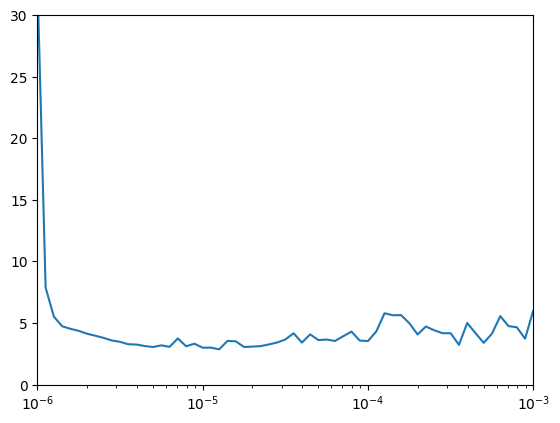

In [17]:
# Plot the loss for every LR
plt.semilogx(lr_history.history['learning_rate'], lr_history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 30])

## Compiling the model

Now that you have trained the model while varying the learning rate, it is time to do the actual training that will be used to forecast the time series. For this complete the `create_model` function below.

Notice that you are reusing the architecture you defined in the `create_uncompiled_model` earlier. Now you only need to compile this model using the appropriate loss, optimizer (and learning rate).

Hint:
- The training should be really quick so if you notice that each epoch is taking more than a few seconds, consider trying a different architecture.


- If after the first epoch you get an output like this: `loss: nan - mae: nan` it is very likely that your network is suffering from exploding gradients. This is a common problem if you used `SGD` as optimizer and set a learning rate that is too high. **If you encounter this problem consider lowering the learning rate or using Adam with the default learning rate.**

In [18]:
def create_model():

    tf.random.set_seed(51)
    
    model = create_uncompiled_model()

    ### START CODE HERE

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5,momentum=0.9),
                  metrics=["mae"])  
    
    ### END CODE HERE

    return model

# Save an instance of the model
model = create_model()

# Train it
history = model.fit(dataset, epochs=50)

In [23]:
model = create_model()
history = model.fit(dataset, epochs=50)

Epoch 1/50


/Users/civye1/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 16.4427 - mae: 16.9335
Epoch 2/50
30/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.2470 - mae: 5.7186

2024-07-10 12:52:00.681519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.1488 - mae: 5.6203
Epoch 3/50
27/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0622 - mae: 4.5258

2024-07-10 12:52:00.906222: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0484 - mae: 4.5131
Epoch 4/50
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.7952 - mae: 4.2597

2024-07-10 12:52:01.155258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.8295 - mae: 4.2922
Epoch 5/50
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2807 - mae: 3.7438

2024-07-10 12:52:01.451672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.3393 - mae: 3.8038
Epoch 6/50
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.9715 - mae: 4.4432

2024-07-10 12:52:01.746242: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.7871 - mae: 4.2562
Epoch 7/50
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9133 - mae: 3.3793

2024-07-10 12:52:02.039887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.1180 - mae: 3.5835
Epoch 8/50
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6228 - mae: 4.0853

2024-07-10 12:52:02.334870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.4660 - mae: 3.9306
Epoch 9/50
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7618 - mae: 3.2222

2024-07-10 12:52:02.628364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0665 - mae: 3.5288
Epoch 10/50
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0046 - mae: 3.4645

2024-07-10 12:52:02.925706: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.0909 - mae: 3.5518
Epoch 11/50
14/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9959 - mae: 3.4457

2024-07-10 12:52:03.256964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.1067 - mae: 3.5580
Epoch 12/50
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9306 - mae: 3.3934

2024-07-10 12:52:03.570891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9668 - mae: 3.4268
Epoch 13/50
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0749 - mae: 3.5322

2024-07-10 12:52:03.869726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0980 - mae: 3.5568
Epoch 14/50
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.4447 - mae: 3.9071

2024-07-10 12:52:04.164190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.3133 - mae: 3.7729
Epoch 15/50
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0131 - mae: 3.4759

2024-07-10 12:52:04.468308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.1124 - mae: 3.5766
Epoch 16/50
11/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.4900 - mae: 2.9519

2024-07-10 12:52:04.769243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8220 - mae: 3.2850
Epoch 17/50
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9839 - mae: 3.4446

2024-07-10 12:52:05.107858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9531 - mae: 3.4154
Epoch 18/50
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8782 - mae: 3.3489

2024-07-10 12:52:05.405584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9653 - mae: 3.4325
Epoch 19/50
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7530 - mae: 3.2086

2024-07-10 12:52:05.698407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8829 - mae: 3.3396
Epoch 20/50
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.1079 - mae: 3.5785

2024-07-10 12:52:05.992672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.1596 - mae: 3.6322
Epoch 21/50
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8218 - mae: 3.2801

2024-07-10 12:52:06.284921: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8424 - mae: 3.3036
Epoch 22/50
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.1272 - mae: 3.5913

2024-07-10 12:52:06.576496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0429 - mae: 3.5080
Epoch 23/50
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9641 - mae: 3.4389

2024-07-10 12:52:06.870360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0626 - mae: 3.5338
Epoch 24/50
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.1855 - mae: 3.6501

2024-07-10 12:52:07.160787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.1530 - mae: 3.6176
Epoch 25/50
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8682 - mae: 3.3335

2024-07-10 12:52:07.449934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8830 - mae: 3.3460
Epoch 26/50
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9431 - mae: 3.4088

2024-07-10 12:52:07.744578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9782 - mae: 3.4428
Epoch 27/50
13/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.7281 - mae: 4.1785

2024-07-10 12:52:08.034773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.3644 - mae: 3.8233
Epoch 28/50
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9456 - mae: 3.4036

2024-07-10 12:52:08.348971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9526 - mae: 3.4121
Epoch 29/50
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0789 - mae: 3.5400

2024-07-10 12:52:08.640286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.1235 - mae: 3.5883
Epoch 30/50
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2389 - mae: 3.7087

2024-07-10 12:52:08.933562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.1195 - mae: 3.5882
Epoch 31/50
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6022 - mae: 3.0612

2024-07-10 12:52:09.224446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7171 - mae: 3.1745
Epoch 32/50
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7354 - mae: 3.1997

2024-07-10 12:52:09.518976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9687 - mae: 3.4331
Epoch 33/50
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7804 - mae: 3.2449

2024-07-10 12:52:09.816758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8128 - mae: 3.2771
Epoch 34/50
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7310 - mae: 3.1825

2024-07-10 12:52:10.117468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7560 - mae: 3.2098
Epoch 35/50
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.5016 - mae: 2.9639

2024-07-10 12:52:10.407774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6135 - mae: 3.0764
Epoch 36/50
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6927 - mae: 3.1466

2024-07-10 12:52:10.700729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7328 - mae: 3.1882
Epoch 37/50
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6365 - mae: 3.0893

2024-07-10 12:52:10.991917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6883 - mae: 3.1431
Epoch 38/50
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2387 - mae: 3.7065

2024-07-10 12:52:11.282680: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.1441 - mae: 3.6109
Epoch 39/50
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7442 - mae: 3.2019

2024-07-10 12:52:11.573489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8194 - mae: 3.2793
Epoch 40/50
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9205 - mae: 3.3894

2024-07-10 12:52:11.865184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9454 - mae: 3.4109
Epoch 41/50
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8054 - mae: 3.2727

2024-07-10 12:52:12.158770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8793 - mae: 3.3458
Epoch 42/50
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7008 - mae: 3.1609

2024-07-10 12:52:12.450569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7603 - mae: 3.2192
Epoch 43/50
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6360 - mae: 4.1030

2024-07-10 12:52:12.741074: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2617 - mae: 3.7279
Epoch 44/50
12/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.8378 - mae: 3.2993

2024-07-10 12:52:13.032736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9885 - mae: 3.4509
Epoch 45/50
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9287 - mae: 3.3815

2024-07-10 12:52:13.350333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8808 - mae: 3.3349
Epoch 46/50
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.1266 - mae: 3.5882

2024-07-10 12:52:13.643194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0551 - mae: 3.5169
Epoch 47/50
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.1579 - mae: 3.6211

2024-07-10 12:52:13.936832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0730 - mae: 3.5358
Epoch 48/50
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6793 - mae: 3.1387

2024-07-10 12:52:14.227379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7091 - mae: 3.1686
Epoch 49/50
14/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.3014 - mae: 3.7642

2024-07-10 12:52:14.519067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0539 - mae: 3.5163
Epoch 50/50
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.1422 - mae: 3.6067

2024-07-10 12:52:14.821764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9387 - mae: 3.4005


2024-07-10 12:52:15.115249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this you can use the `compute_metrics` function that you coded in a previous assignment:

In [20]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mse(true_series, forecast).numpy()
    mae = tf.keras.metrics.mae(true_series, forecast).numpy()

    return mse, mae

At this point only the model that will perform the forecast is ready but you still need to compute the actual forecast. 

## Faster model forecasts

In the previous week you used a for loop to compute the forecasts for every point in the sequence. This approach is valid but there is a more efficient way of doing the same thing by using batches of data. The code to implement this is provided in the `model_forecast` below. Notice that the code is very similar to the one in the `windowed_dataset` function with the differences that:

- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

In [24]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2024-07-10 12:57:38.067157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


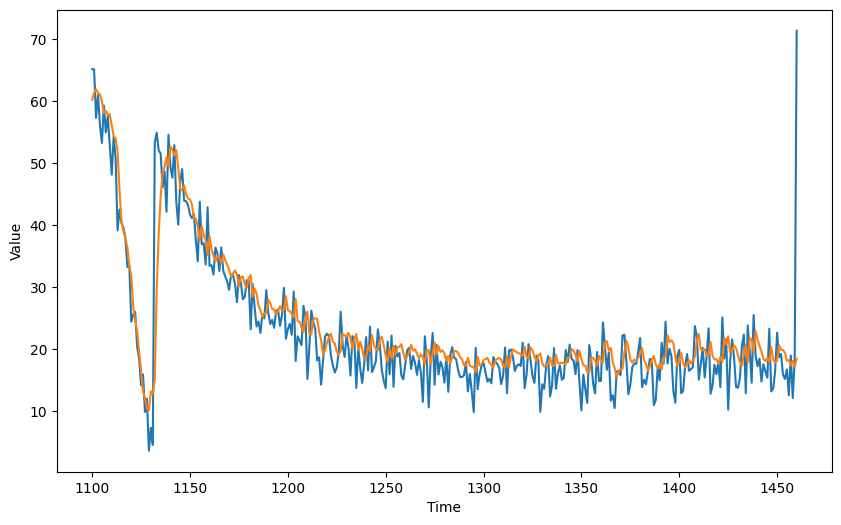

In [26]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot it
plt.figure(figsize=(10, 6))

plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

**Expected Output:**

A series similar to this one:

<div>
<img src="images/expected.png" width="500"/>
</div>

In [27]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 29.89, mae: 3.54 for forecast


**To pass this assignment your forecast should achieve an MAE of 4.5 or less.**

- If your forecast didn't achieve this threshold try re-training your model with a different architecture (you will need to re-run both `create_uncompiled_model` and `create_model` functions) or tweaking the optimizer's parameters.


- If your forecast did achieve this threshold run the following cell to save your model in a `tar` file which will be used for grading and after doing so, submit your assigment for grading.


- This environment includes a dummy `SavedModel` directory which contains a dummy model trained for one epoch. **To replace this file with your actual model you need to run the next cell before submitting for grading.**


- Unlike last week, this time the model is saved using the `SavedModel` format. This is done because the HDF5 format does not fully support `Lambda` layers.

In [33]:
# Save your model in the SavedModel format
model.save('saved_model/my_model')

# Compress the directory using tar
! tar -czvf saved_model.tar.gz saved_model/

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=saved_model/my_model.

**Congratulations on finishing this week's assignment!**

You have successfully implemented a neural network capable of forecasting time series leveraging Tensorflow's layers for sequence modelling such as `RNNs` and `LSTMs`! **This resulted in a forecast that matches (or even surpasses) the one from last week while training for half of the epochs.**

**Keep it up!**